<a href="https://colab.research.google.com/github/rodrigoamorimml/NaturalLanguageProcessing/blob/master/SpamDetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Text Binary Classification Example - Spam Detection 
# The Dataset can be found at: https://www.kaggle.com/uciml/sms-spam-collection-dataset

# Import Libraries

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
from google.colab import files

uploaded = files.upload()

Saving spam.csv to spam.csv


In [3]:
data = pd.read_csv('spam.csv', encoding = 'ISO-8859-1')  # Need to use this type os encoding to open the file with pandas
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [4]:
data.columns

Index(['v1', 'v2', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], dtype='object')

In [5]:
data.drop(columns= ['Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'], inplace = True)  # we drop the last three columns (don't need them)

In [6]:
data.head()

,v1,v2
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [7]:
# As we can see, the first column are the labels and the second column is the text comments that will be use as  neural network input.
# We need to change the output values to numeric values, ANN work's better with them.

data['labels'] = np.where(data.v1 == 'spam', 1, 0)
data.head()


,v1,v2,labels
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


In [8]:
y = data['labels'].values
print(y.shape)

(5572,)


In [9]:
# Split the data into train and test set
from sklearn.model_selection import train_test_split

x_train, x_test , y_train, y_test = train_test_split(data['v2'], y, test_size = .3, random_state = 42)
print(x_train.shape)
print(x_test.shape)

(3900,)
(1672,)


In [10]:
# Now we need to process the text comments, like we use for the labels, we need to transform the text in numeric values, for this we use the tokenizer
# tokenizer takes a sentence split in each word and take a unique integer for every word in the vocabulary, for this we first need to set a max vocab size
Max_Vocab_Size = 20000 # Common value used for english language

# Necessary imports

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

tokenizer = Tokenizer(num_words = Max_Vocab_Size)
tokenizer.fit_on_texts(x_train)  # Fit using the train set

x_train_seq = tokenizer.texts_to_sequences(x_train) # transform the sentence into a sequence  of integers
x_test_seq = tokenizer.texts_to_sequences(x_test)



In [11]:
# Pad the sequences to get the format of N x T ~> Samples x Sequence Length

x_train_pad = pad_sequences(x_train_seq)
T = x_train_pad.shape[1] 
print(T)
print(x_train_pad.shape)

121
(3900, 121)


In [12]:
# We pad the test set using the T equals to 121

x_test_pad = pad_sequences(x_test_seq, maxlen = T)
x_test_pad.shape


(1672, 121)

In [13]:
# We need to know the size of our vocabulary

word2idx = tokenizer.word_index

V = len(word2idx) + 1 # The vocabulary start with 1, 0 its used for padding
print(f'Number of unique words {V}')

Number of unique words 7414


**Creating a RNN Model**

In [14]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, Flatten, LSTM, Conv1D, GlobalMaxPooling1D, Embedding

i = Input(shape = (T,)) # the input shape expected is the sequence length

x = Embedding(V, 25)(i) # Expect the vocab size and the embedding dimension 
x = LSTM(20, return_sequences = True)(x) 
x = GlobalMaxPooling1D()(x)  # It's good for long term dependencies

x = Dense(1, activation = 'sigmoid')(x)  # we use sigmoid activation function for binary classification

model_rnn = Model(i, x) 

model_rnn.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
embedding (Embedding)        (None, 121, 25)           185350    
_________________________________________________________________
lstm (LSTM)                  (None, 121, 20)           3680      
_________________________________________________________________
global_max_pooling1d (Global (None, 20)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 21        
Total params: 189,051
Trainable params: 189,051
Non-trainable params: 0
_________________________________________________________________


In [15]:
model_rnn.compile(loss = 'binary_crossentropy',
              optimizer = 'adam',
              metrics = ['acc'])

r = model_rnn.fit(x_train_pad, y_train, epochs = 10, validation_data = (x_test_pad, y_test))

Epoch 1/10
122/122 [==============================] - 2s 18ms/step - loss: 0.4073 - acc: 0.8641 - val_loss: 0.2698 - val_acc: 0.8690
Epoch 2/10
122/122 [==============================] - 2s 13ms/step - loss: 0.2087 - acc: 0.9159 - val_loss: 0.1813 - val_acc: 0.9647
Epoch 3/10
122/122 [==============================] - 2s 13ms/step - loss: 0.1272 - acc: 0.9887 - val_loss: 0.1239 - val_acc: 0.9833
Epoch 4/10
122/122 [==============================] - 2s 13ms/step - loss: 0.0769 - acc: 0.9946 - val_loss: 0.1004 - val_acc: 0.9797
Epoch 5/10
122/122 [==============================] - 2s 13ms/step - loss: 0.0433 - acc: 0.9982 - val_loss: 0.0846 - val_acc: 0.9803
Epoch 6/10
122/122 [==============================] - 2s 13ms/step - loss: 0.0265 - acc: 0.9985 - val_loss: 0.0650 - val_acc: 0.9850
Epoch 7/10
122/122 [==============================] - 2s 13ms/step - loss: 0.0171 - acc: 0.9992 - val_loss: 0.0640 - val_acc: 0.9850
Epoch 8/10
122/122 [==============================] - 2s 13ms/step - 

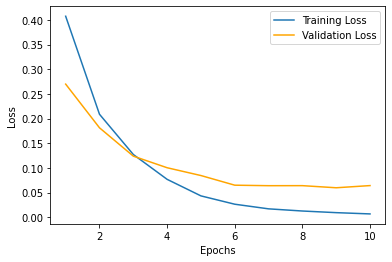

In [16]:
epochs = range(1, len(r.history['loss']) + 1)

plt.plot(epochs, r.history['loss'],  label = 'Training Loss')
plt.plot(epochs, r.history['val_loss'], color = 'orange', label = 'Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('')
plt.show()

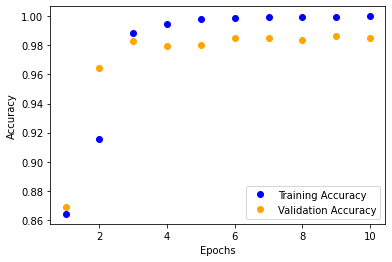

In [17]:
plt.plot(epochs, r.history['acc'], 'bo', label = 'Training Accuracy')
plt.plot(epochs, r.history['val_acc'], 'bo', color = 'orange', label = 'Validation Accuracy')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
# We archive an accuracy validation of 98% using LSTM for our model

**Creating a CNN Model**

In [22]:
from tensorflow.keras.layers import MaxPooling1D

i = Input(shape = (T,))
x = Embedding(V, 25)(i)

x = Conv1D(32, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = MaxPooling1D(3)(x)
x = Conv1D(64, 3, activation = 'relu')(x)
x = GlobalMaxPooling1D()(x)

x = Dense(1, activation = 'sigmoid')(x)

model_cnn = Model(i, x)

model_cnn.summary()


Model: "functional_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_5 (InputLayer)         [(None, 121)]             0         
_________________________________________________________________
embedding_4 (Embedding)      (None, 121, 25)           185350    
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 119, 32)           2432      
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 39, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 37, 64)            6208      
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 12, 64)            0         
_________________________________________________________________
conv1d_4 (Conv1D)            (None, 10, 64)           

In [23]:
model_cnn.compile(loss = 'binary_crossentropy',
                  optimizer = 'adam',
                  metrics = ['acc'])

r = model_cnn.fit(x_train_pad, y_train, epochs = 10, validation_data = (x_test_pad, y_test))

Epoch 1/10
122/122 [==============================] - 1s 11ms/step - loss: 0.4232 - acc: 0.8590 - val_loss: 0.3301 - val_acc: 0.8690
Epoch 2/10
122/122 [==============================] - 1s 9ms/step - loss: 0.1312 - acc: 0.9515 - val_loss: 0.1151 - val_acc: 0.9743
Epoch 3/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0297 - acc: 0.9913 - val_loss: 0.1347 - val_acc: 0.9749
Epoch 4/10
122/122 [==============================] - 1s 9ms/step - loss: 0.0138 - acc: 0.9962 - val_loss: 0.1179 - val_acc: 0.9767
Epoch 5/10
122/122 [==============================] - 1s 9ms/step - loss: 0.0076 - acc: 0.9979 - val_loss: 0.1733 - val_acc: 0.9755
Epoch 6/10
122/122 [==============================] - 1s 9ms/step - loss: 0.0057 - acc: 0.9985 - val_loss: 0.1515 - val_acc: 0.9773
Epoch 7/10
122/122 [==============================] - 1s 8ms/step - loss: 0.0036 - acc: 0.9990 - val_loss: 0.1453 - val_acc: 0.9755
Epoch 8/10
122/122 [==============================] - 1s 9ms/step - loss: 0

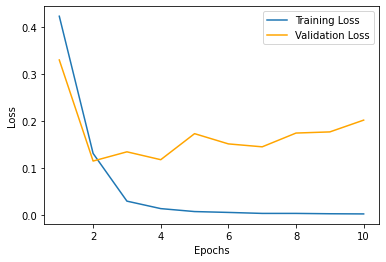

In [24]:
epochs = range(1, len(r.history['loss']) + 1)

plt.plot(epochs, r.history['loss'],  label = 'Training Loss')
plt.plot(epochs, r.history['val_loss'], color = 'orange', label = 'Validation Loss')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('')
plt.show()

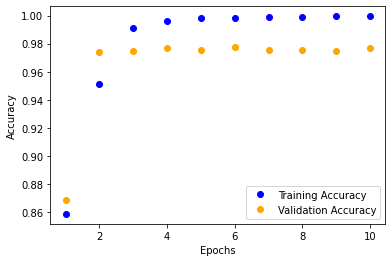

In [25]:
plt.plot(epochs, r.history['acc'], 'bo', label = 'Training Accuracy')
plt.plot(epochs, r.history['val_acc'], 'bo', color = 'orange', label = 'Validation Accuracy')
plt.legend(loc = 'best')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()
# We archive an accuracy validation of 97% using ConvNets for our model